In [36]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import keras
import numpy as np
from keras.layers import Dropout
from keras.utils import plot_model
import matplotlib.pyplot as plt

def split_dataset(data, dias, lim_treino):
    train, test = data[:lim_treino], data[lim_treino:]
    train = array(split(train, len(train)/dias))
    test = array(split(test, len(test)/dias))
    return train, test

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        in_start += 1 #movimento pra criacao de outputs
    return array(X), array(y)

def build_model(train, n_input, dias):
    train_x, train_y = to_supervised(train, n_input, dias)
    
    verbose, epochs, batch_size = 1, 100, 32
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(LSTM(64, activation='relu',return_sequences=False))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(128, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(1)))
    otimizador = keras.optimizers.RMSprop(lr=0.002, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mae', optimizer=otimizador)
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False,
              validation_split = 0.001)
    model.save('resultado20.h5')
    
    model.summary()
    
    return model

def forecast(model, history, n_input):
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2])) #
    input_x = data[-n_input:, :] #ultimas informacoes pra entrada
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

def predizer(train, test, n_input, dias, model):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])
    return array(predictions)

#### Analise de previsao de 5 dias

In [18]:
dias = 5
n_input = 15
amostras = 2800
lim_treino = amostras - dias

In [19]:
df = read_csv('./preprocessing/preprocessed.csv')

In [20]:
df = df.iloc[:amostras]

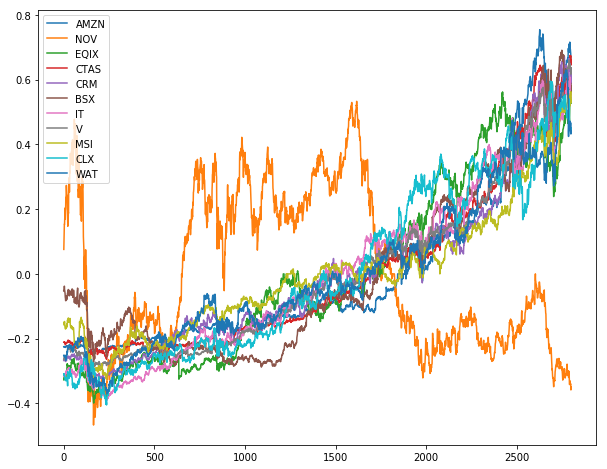

In [21]:
plt.figure(figsize=(10,8))
for x in df.columns:
    plt.plot(df[x], label = x)
plt.legend()    
plt.show()

In [22]:
df.drop(labels = 'NOV', axis = 1, inplace = True)

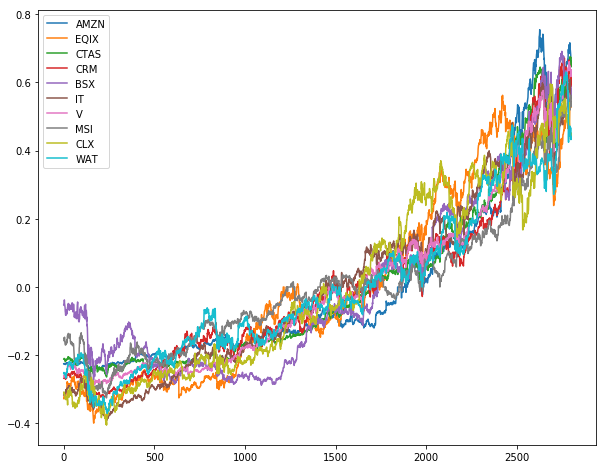

In [23]:
plt.figure(figsize=(10,8))
for x in df.columns:
    plt.plot(df[x], label = x)
plt.legend()    
plt.show()

In [24]:
train, test = split_dataset(df.values, dias, lim_treino)

In [27]:
print(train.shape, test.shape)
print(train[:2])
print(test[:2])

(559, 5, 10) (1, 5, 10)
[[[-0.22482939 -0.3273274  -0.2112316  -0.26773026 -0.05182162
   -0.31627983 -0.26465628 -0.15690847 -0.30834463 -0.25199441]
  [-0.22449514 -0.32426237 -0.20958188 -0.26605802 -0.05209518
   -0.31386326 -0.26355369 -0.15321061 -0.31282746 -0.25060052]
  [-0.22570742 -0.32461925 -0.21008597 -0.26528383 -0.05401011
   -0.31164264 -0.25861535 -0.14898451 -0.31000494 -0.25482715]
  [-0.22474458 -0.31743951 -0.20962771 -0.2616916  -0.03787005
   -0.31112014 -0.26019934 -0.15162581 -0.31332552 -0.25509692]
  [-0.22472961 -0.32142824 -0.21045257 -0.26179999 -0.04799178
   -0.31138139 -0.2593297  -0.14713559 -0.31606504 -0.25694045]]

 [[-0.22453006 -0.32014764 -0.21136907 -0.26368901 -0.05100094
   -0.31027108 -0.25459324 -0.15638022 -0.3148198  -0.25419764]
  [-0.22598181 -0.32293977 -0.21356868 -0.26457158 -0.05565147
   -0.31569202 -0.25816499 -0.1611346  -0.32287228 -0.25329837]
  [-0.2257623  -0.3171246  -0.21301878 -0.26090195 -0.06084912
   -0.30876888 -0.2576

In [38]:
X_train, y_train = to_supervised(train, n_input, dias)
print(X_train.shape, y_train.shape)

(2775, 15, 10) (2775, 5)


In [37]:
model = build_model(train, n_input, dias)

15 10 5
Train on 2772 samples, validate on 3 samples
Epoch 1/100
2772/2772 [==============================] - 5s 2ms/step - loss: 0.0698 - val_loss: 0.1762
Epoch 2/100
2772/2772 [==============================] - 3s 998us/step - loss: 0.3536 - val_loss: 0.1204
Epoch 3/100
2772/2772 [==============================] - 3s 940us/step - loss: 0.0668 - val_loss: 0.0355
Epoch 4/100
2772/2772 [==============================] - 3s 987us/step - loss: 0.1027 - val_loss: 0.0276
Epoch 5/100
2772/2772 [==============================] - 3s 1ms/step - loss: 0.0613 - val_loss: 0.0615
Epoch 6/100
2772/2772 [==============================] - 4s 1ms/step - loss: 0.0658 - val_loss: 0.0153
Epoch 7/100
2772/2772 [==============================] - 3s 1ms/step - loss: 0.0560 - val_loss: 0.0219
Epoch 8/100
2772/2772 [==============================] - 3s 1ms/step - loss: 0.0511 - val_loss: 0.0225
Epoch 9/100
2772/2772 [==============================] - 3s 1ms/step - loss: 0.0660 - val_loss: 0.0581
Epoch 10/100
2

In [11]:
pred = predizer(train, test, n_input, dias, model)

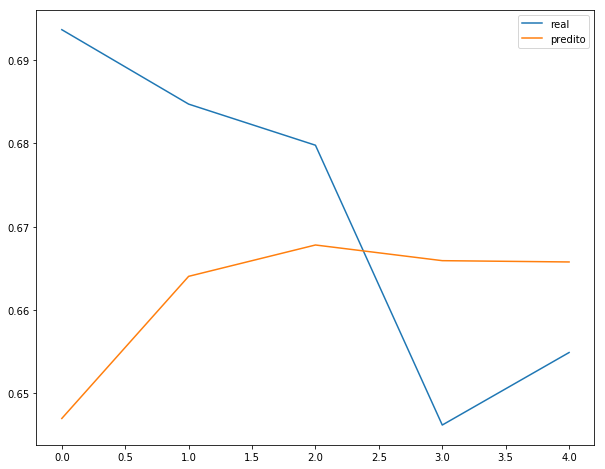

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test[0,:,0].flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [13]:
pred = predizer(train, train, n_input, dias, model)

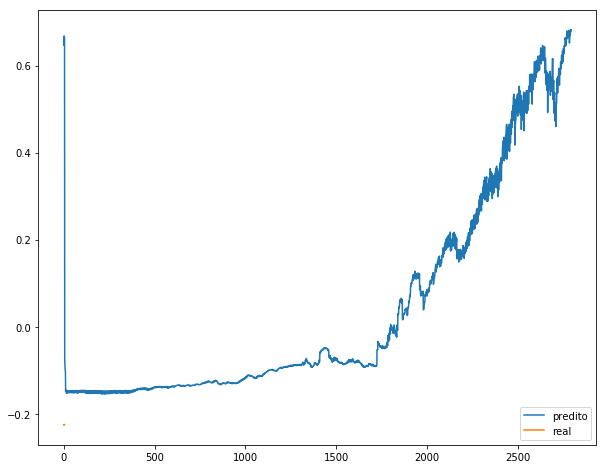

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(pred.flatten(), label = 'predito')
plt.plot(train[0,:,0].flatten(), label = 'real')
plt.legend()
plt.show()

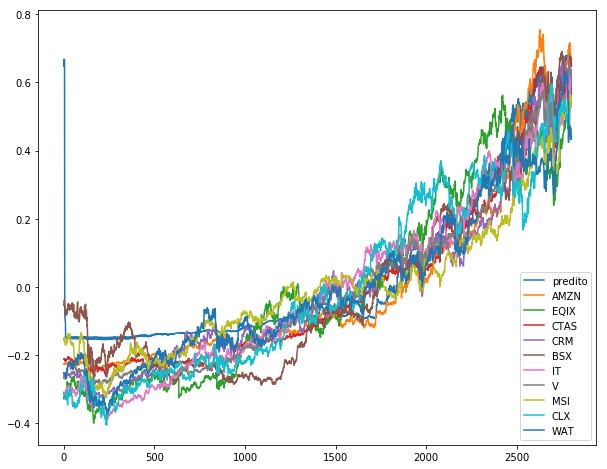

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(pred.flatten(), label = 'predito')
for x in df.columns:
    plt.plot(df[x], label = x)
plt.legend()
plt.show()

#### IT

In [31]:
model = build_model(train, n_input, dias)

Train on 2772 samples, validate on 3 samples
Epoch 1/50
2772/2772 [==============================] - 8s 3ms/step - loss: 0.6890 - val_loss: 0.4888
Epoch 2/50
2772/2772 [==============================] - 4s 1ms/step - loss: 0.6127 - val_loss: 0.2917
Epoch 3/50
2772/2772 [==============================] - 4s 1ms/step - loss: 0.2020 - val_loss: 0.2141
Epoch 4/50
2772/2772 [==============================] - 4s 1ms/step - loss: 0.1572 - val_loss: 0.3690
Epoch 5/50
2772/2772 [==============================] - 5s 2ms/step - loss: 0.2913 - val_loss: 0.3816
Epoch 6/50
2772/2772 [==============================] - 4s 1ms/step - loss: 0.1396 - val_loss: 0.3873
Epoch 7/50
2772/2772 [==============================] - 4s 1ms/step - loss: 0.1265 - val_loss: 0.2714
Epoch 8/50
2772/2772 [==============================] - 4s 1ms/step - loss: 0.1304 - val_loss: 0.3506
Epoch 9/50
2772/2772 [==============================] - 4s 1ms/step - loss: 0.1426 - val_loss: 0.0460
Epoch 10/50
2772/2772 [==============

In [32]:
pred = predizer(train, test, n_input, dias, model)

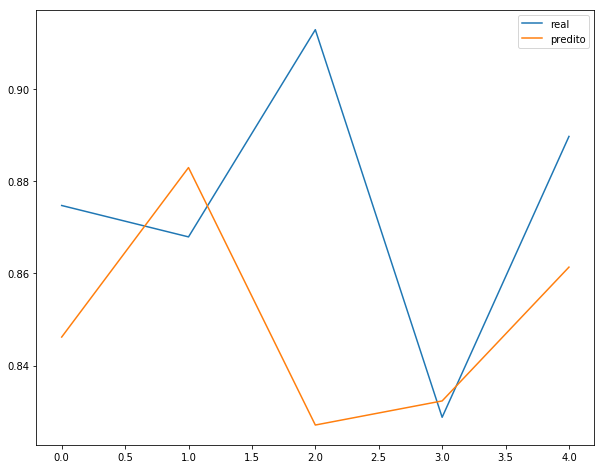

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test[0,:,3].flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [34]:
pred = predizer(train, train, n_input, dias, model)

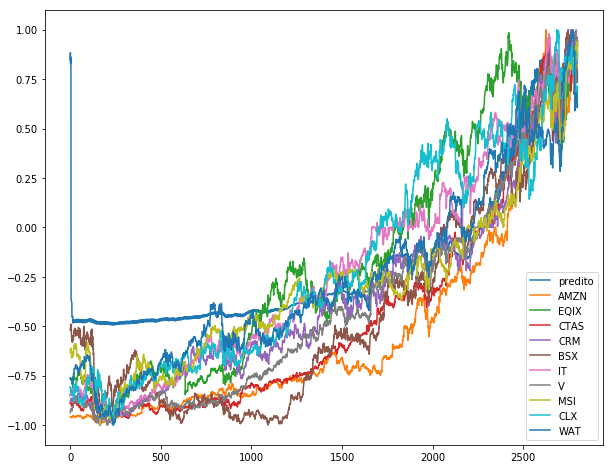

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(pred.flatten(), label = 'predito')
for x in df.columns:
    plt.plot(df[x], label = x)
plt.legend()
plt.show()

#### Prevendo 10 dias

In [57]:
dias = 10
n_input = 30
amostras = 2800
lim_treino = amostras - dias

In [58]:
train, test = split_dataset(df.values, dias, lim_treino)

In [59]:
model = build_model(train, n_input, dias)

Train on 2747 samples, validate on 3 samples
Epoch 1/50
2747/2747 [==============================] - 14s 5ms/step - loss: 15825.0728 - val_loss: 1.0014
Epoch 2/50
2747/2747 [==============================] - 9s 3ms/step - loss: 41.4390 - val_loss: 0.4187
Epoch 3/50
2747/2747 [==============================] - 8s 3ms/step - loss: 0.3685 - val_loss: 0.4743
Epoch 4/50
2747/2747 [==============================] - 7s 3ms/step - loss: 0.4057 - val_loss: 0.5356
Epoch 5/50
2747/2747 [==============================] - 8s 3ms/step - loss: 0.2303 - val_loss: 0.1367
Epoch 6/50
2747/2747 [==============================] - 7s 3ms/step - loss: 0.7307 - val_loss: 0.1096
Epoch 7/50
2747/2747 [==============================] - 7s 3ms/step - loss: 0.1376 - val_loss: 0.1667
Epoch 8/50
2747/2747 [==============================] - 8s 3ms/step - loss: 1.0649 - val_loss: 0.1722
Epoch 9/50
2747/2747 [==============================] - 8s 3ms/step - loss: 0.1654 - val_loss: 0.0959
Epoch 10/50
2747/2747 [========

In [60]:
pred = predizer(train, test, n_input, dias, model)

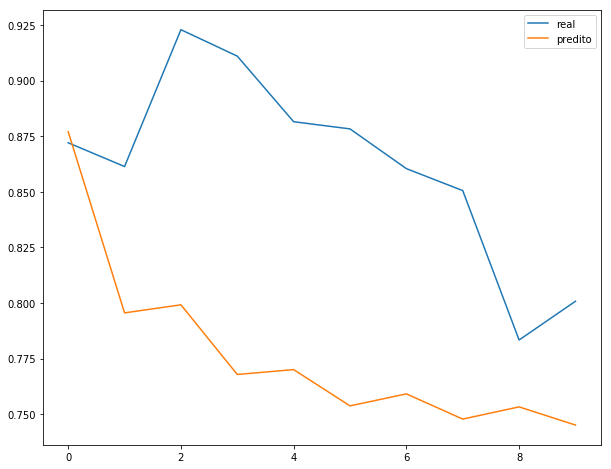

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test[0,:,0].flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [62]:
pred = predizer(train, train, n_input, dias, model)

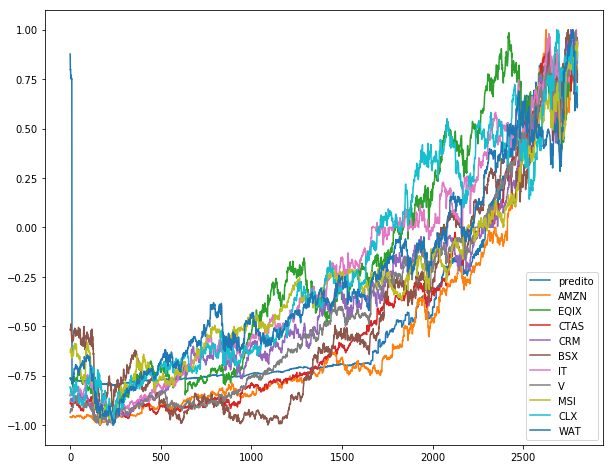

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(pred.flatten(), label = 'predito')
for x in df.columns:
    plt.plot(df[x], label = x)
plt.legend()
plt.show()

#### Prevendo 20 dias

In [65]:
dias = 20
n_input = 60
amostras = 2800
lim_treino = amostras - dias

In [66]:
train, test = split_dataset(df.values, dias, lim_treino)

In [67]:
model = build_model(train, n_input, dias)

Train on 2697 samples, validate on 3 samples
Epoch 1/50
2697/2697 [==============================] - 19s 7ms/step - loss: 141268140690.5823 - val_loss: 2163.3086
Epoch 2/50
2697/2697 [==============================] - 13s 5ms/step - loss: 63173.2886 - val_loss: 31.0809
Epoch 3/50
2697/2697 [==============================] - 13s 5ms/step - loss: 990.6138 - val_loss: 2838.8906
Epoch 4/50
2697/2697 [==============================] - 13s 5ms/step - loss: 3.5558 - val_loss: 0.4011
Epoch 5/50
2697/2697 [==============================] - 14s 5ms/step - loss: 0.1780 - val_loss: 0.3978
Epoch 6/50
2697/2697 [==============================] - 15s 6ms/step - loss: 0.1506 - val_loss: 0.1413
Epoch 7/50
2697/2697 [==============================] - 18s 7ms/step - loss: 0.1498 - val_loss: 0.1270
Epoch 8/50
2697/2697 [==============================] - 13s 5ms/step - loss: 0.4721 - val_loss: 0.1006
Epoch 9/50
2697/2697 [==============================] - 16s 6ms/step - loss: 0.1299 - val_loss: 0.2560
Epoc

In [68]:
pred = predizer(train, test, n_input, dias, model)

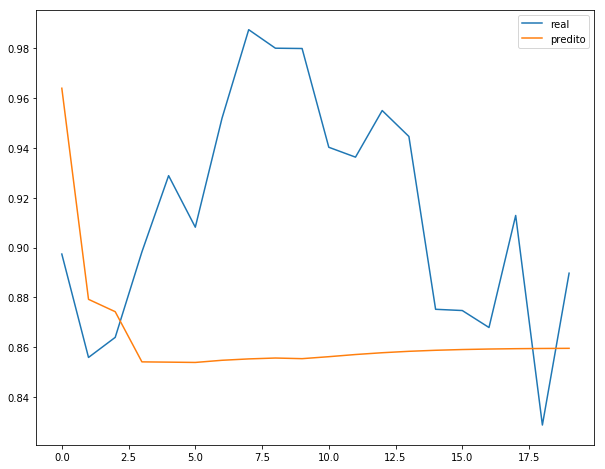

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(test[0,:,3].flatten(), label = 'real')
plt.plot(pred.flatten(), label = 'predito')
plt.legend()
plt.show()

In [70]:
pred = predizer(train, train, n_input, dias, model)

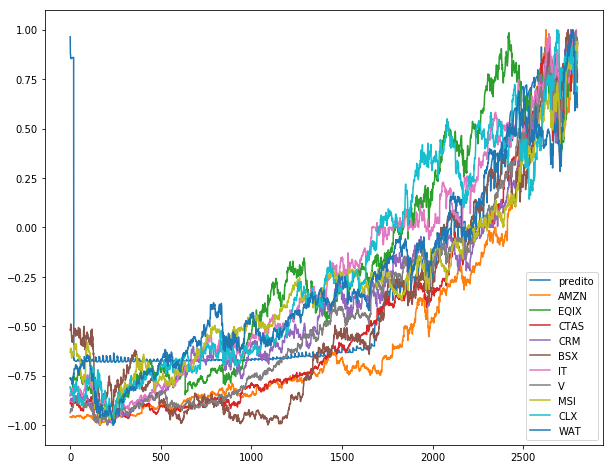

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(pred.flatten(), label = 'predito')
for x in df.columns:
    plt.plot(df[x], label = x)
plt.legend()
plt.show()